# Compute SNR

Calculate the SNR of the recordings in the test dataset.

(Rado's implementation of SNR functions is provided at the bottom of the notebook).

**Author**: Prisca Dotti  
**Last modified**: 30/10/2023

TODO (week 44):
- ~~compute snr wrt to events only on chunk that contains them instead of all movie~~ -> does not improve results much (correlation from 0.356 to 0.392)
- ~~change range (`max_range`) in snr wrt to chunks~~ -> results can improve a bit, but I don't know what is the most legitimate choice for `max_range` (corr. went from 0.589 to 0.596 with `max_range` changed from 16 to 24
)
- ~~try different values of percentile for events in `compute_snr` to see if all events are represented in the percentile mask~~
    - for whole movies: it is basically impossible to include all events
    - for single frames: 99 is clearly too much, 70 not enough, 60 is okay in almost all frames, but then the correlation value gets event worse
    - for chunks of frames: 99 is mostly okay
    - for average of events: 99 is maybe even too small


In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import sys

# To import modules from parent directory in Jupyter Notebook
sys.path.append("..")

In [2]:
import logging
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import napari

from utils.in_out_tools import load_movies_ids, load_annotations_ids
from data.data_processing_tools import (
    compute_snr,
    moving_average,
    keep_percentile,
    # get_cell_mask
)

logger = logging.getLogger(__name__)
sns.set_theme(style="ticks", palette="hls")

#### Set working directories and parameters

In [3]:
# list of all movie IDs in test set
sample_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
# sample_ids = ["05", "34"]

relative_path = "../data/sparks_dataset"
dataset_path = os.path.realpath(f"{relative_path}")

In [4]:
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}

movie_id_to_slice = {v: k for k, v in slice_to_movie_id.items()}
slice_ids = list(slice_to_movie_id.keys())

slice_to_frame_id = {
    "01": 54,
    "02": 445,
    "03": 430,
    "04": 351,
    "05": 410,
    "06": 109,
    "07": 950,
    "08": 894,
    "09": 898,
    "10": 667,
}

#### Load recordings

In [5]:
# load movies
xs = load_movies_ids(
    data_folder=dataset_path, ids=sample_ids, names_available=True, movie_names="video"
)

# load annotations
ys = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="class_label"
)

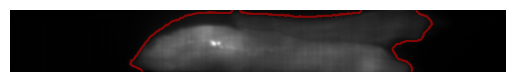

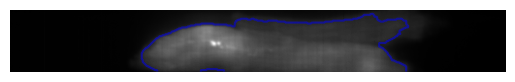

In [69]:
from data.data_processing_tools import get_cell_mask

sample_id = "34"
x = xs[sample_id]
y = ys[sample_id]
cell_mask = get_cell_mask(x)

# plot image and contours
fig, ax = plt.subplots()
ax.imshow(np.mean(x, axis=0), cmap="gray")
ax.contour(cell_mask, colors="red", alpha=0.5)
ax.axis("off")
plt.show()

rado_cell_mask = estimate_cell_mask(x)

# plot image and contours
fig, ax = plt.subplots()
ax.imshow(np.mean(x, axis=0), cmap="gray")
ax.contour(rado_cell_mask, colors="blue", alpha=0.5)
ax.axis("off")
plt.show()

## Get Fleiss' Kappa values

In [7]:
# Fleiss' Kappa for inter-rater agreement
fleiss_kappas = {
    "01": 0.4,
    "02": 0.263,
    "03": 0.393,
    "04": 0.499,
    "05": 0.411,
    "06": 0.210,
    "07": 0.140,
    "08": 0.635,
    "09": 0.817,
    "10": 0.776,
}

binary_fleiss_kappas = {
    "01": 0.423724,
    "02": 0.379940,
    "03": 0.535884,
    "04": 0.626976,
    "05": 0.587802,
    "06": 0.275065,
    "07": 0.140142,
    "08": 0.764101,
    "09": 0.820575,
    "10": 0.775755,
}

fleiss_kappas_list = [
    kappa
    for slice_id, kappa in fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

binary_fleiss_kappas_list = [
    kappa
    for slice_id, kappa in binary_fleiss_kappas.items()
    if slice_to_movie_id[slice_id] in sample_ids
]

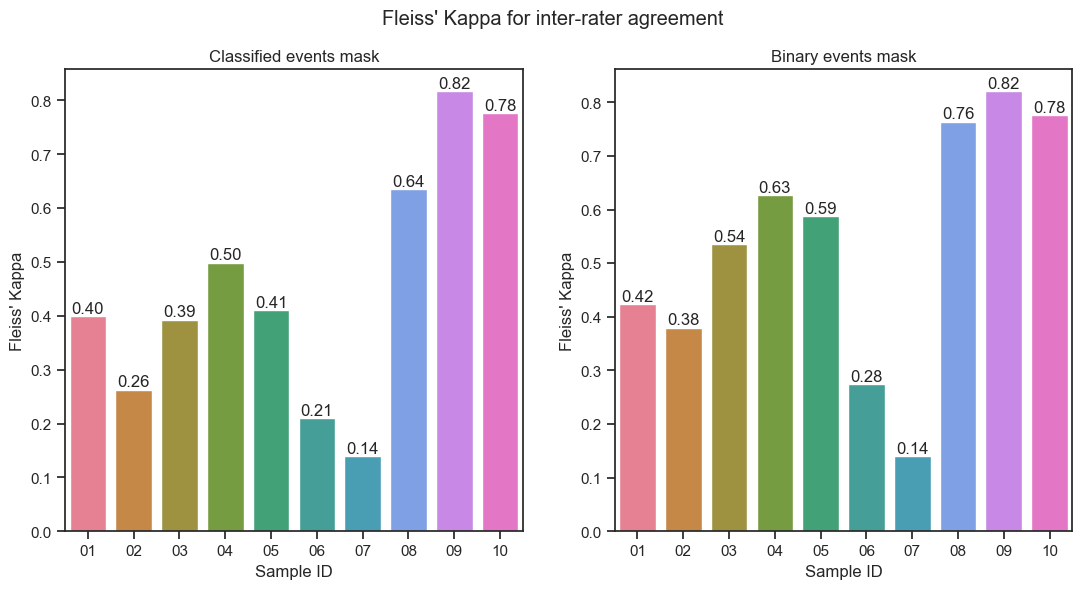

In [8]:
# create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 6))

# visualize snr and fleiss kappas as scatterplot
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=fleiss_kappas_list,
    ax=ax1,
    legend=False,
)
ax1.set_title("Classified events mask")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("Fleiss' Kappa")
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")

# visualize snr and binary fleiss kappas as scatterplot
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
)
ax2.set_title("Binary events mask")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")

# set figure title
fig.suptitle("Fleiss' Kappa for inter-rater agreement")

# display the plot
plt.show()

## Compute SNR using various approaches

#### For whole movie

In [70]:
snr = {}
percentile = 90

for sample_id in sample_ids:
    # get sample
    x = xs[sample_id]
    # get annotations
    y = ys[sample_id]

    # compute signal-to-noise ratio
    snr[sample_id] = compute_snr(x, y, percentile=percentile)

# get snr with respect to samples given to experts for inter-rater agreement
snr_experts = {
    slice_id: snr[slice_to_movie_id[slice_id]]
    for slice_id in slice_ids
    if slice_to_movie_id[slice_id] in sample_ids
}

#### Compute correlation with Fleiss' kappa for whole movies

In [71]:
# check if there is a correlation between snr and fleiss kappas
snr_experts_list = list(snr_experts.values())
whole_movie_corr, _ = pearsonr(snr_experts_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % whole_movie_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_whole_movie_corr, _ = pearsonr(snr_experts_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_whole_movie_corr)

Pearsons correlation for classified segmentation: 0.343
Pearsons correlation for binary segmentation: 0.504


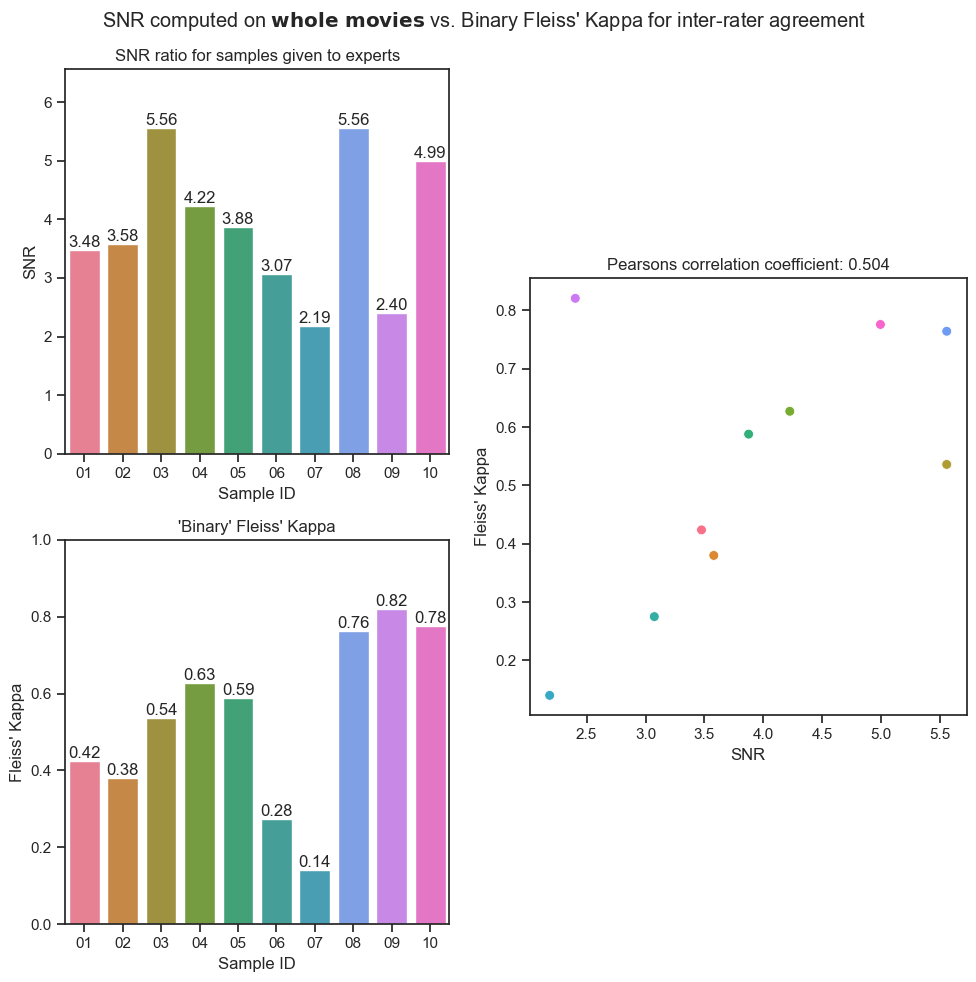

In [72]:
# create a figure with 3 subplots
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])

# plot barplot of snr_experts
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x=slice_ids, hue=slice_ids, y=snr_experts_list, ax=ax1, legend=False, orient="v"
)
ax1.set_title("SNR ratio for samples given to experts")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("SNR")
ax1.set_ylim(0, max(snr_experts_list) + 1)
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")
ax1.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot barplot of binary_fleiss_kappas
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
    orient="v",
)
ax2.set_title("'Binary' Fleiss' Kappa")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
ax2.set_ylim(0, 1)
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")
ax2.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot scatter plot of snr_experts_list vs binary_fleiss_kappas_list
ax3 = fig.add_subplot(gs[:, 1])
sns.scatterplot(
    x=snr_experts_list,
    y=binary_fleiss_kappas_list,
    hue=slice_ids,
    hue_order=slice_ids,
    ax=ax3,
    legend=False,
    s=50,
)
ax3.set_title("Pearsons correlation coefficient: %.3f" % binary_whole_movie_corr)
ax3.set_xlabel("SNR")
ax3.set_ylabel("Fleiss' Kappa")
ax3.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# set the whole plot title
fig.suptitle(
    r"SNR computed on $\bf{whole\ movies}$ vs. Binary Fleiss' Kappa for inter-rater agreement"
)

# remove empty space between columns
fig.subplots_adjust(wspace=0)
fig.tight_layout()

# display the plot
plt.show()

In [22]:
# # visualize pixels in events above percentile

# slice_id = slice_ids[7]
# x = xs[slice_to_movie_id[slice_id]]
# y = ys[slice_to_movie_id[slice_id]]

# # compute percentile
# percentile = 50
# events_percentile = np.percentile(x[y != 0], percentile)
# percentile_mask = np.logical_and(x > events_percentile, y != 0)

# viewer = napari.Viewer()
# viewer.add_image(
#     x, name=f"movie {slice_to_movie_id[slice_id]}", colormap="gray", opacity=0.5
# )
# viewer.add_labels(y, name=f"events in movie {slice_to_movie_id[slice_id]}", opacity=0.5)
# viewer.add_labels(
#     percentile_mask, name="pixels in events above percentile", blending="additive"
# )

#### Compute SNR for single frames

In [74]:
snr_frames = {}
percentile = 90

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get sample frame
    x = xs[movie_id][frame_id]
    # get annotations frame
    y = ys[movie_id][frame_id]

    # compute signal-to-noise ratio
    snr_frames[slice_id] = compute_snr(x, y, percentile=percentile)

#### Compute correlation for single frames

In [75]:
# check if there is a correlation between snr and fleiss kappas
snr_frames_list = list(snr_frames.values())
single_frame_corr, _ = pearsonr(snr_frames_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % single_frame_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_single_frame_corr, _ = pearsonr(snr_frames_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_single_frame_corr)

Pearsons correlation for classified segmentation: 0.004
Pearsons correlation for binary segmentation: 0.208


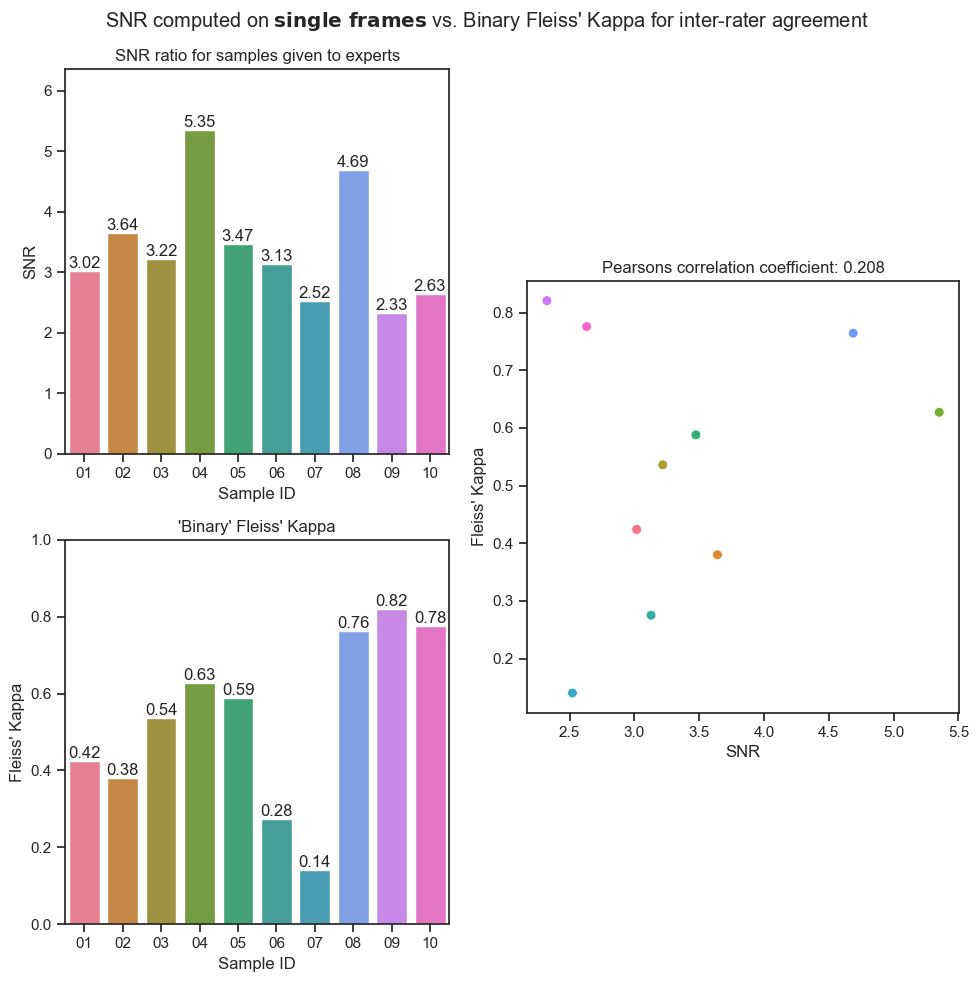

In [76]:
# create a figure with 3 subplots
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])

# plot barplot of snr_experts
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x=slice_ids, hue=slice_ids, y=snr_frames_list, ax=ax1, legend=False, orient="v"
)
ax1.set_title("SNR ratio for samples given to experts")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("SNR")
ax1.set_ylim(0, max(snr_frames.values()) + 1)
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")
ax1.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot barplot of binary_fleiss_kappas
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
    orient="v",
)
ax2.set_title("'Binary' Fleiss' Kappa")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
ax2.set_ylim(0, 1)
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")
ax2.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot scatter plot of snr_experts_list vs binary_fleiss_kappas_list
ax3 = fig.add_subplot(gs[:, 1])
sns.scatterplot(
    x=snr_frames_list,
    y=binary_fleiss_kappas_list,
    hue=slice_ids,
    hue_order=slice_ids,
    ax=ax3,
    legend=False,
    s=50,
)
ax3.set_title("Pearsons correlation coefficient: %.3f" % binary_single_frame_corr)
ax3.set_xlabel("SNR")
ax3.set_ylabel("Fleiss' Kappa")
ax3.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# set the whole plot title
fig.suptitle(
    r"SNR computed on $\bf{single\ frames}$ vs. Binary Fleiss' Kappa for inter-rater agreement"
)

# remove empty space between columns
fig.subplots_adjust(wspace=0)
fig.tight_layout()

# display the plot
plt.show()

In [88]:
# # visualize pixels in events above percentile
# for slice_id in slice_ids:
#     # slice_id = slice_ids[0]
#     movie_id = slice_to_movie_id[slice_id]
#     frame_id = slice_to_frame_id[slice_id]

#     x = xs[movie_id][frame_id]
#     y = ys[movie_id][frame_id]

#     # compute percentile
#     percentile = 60
#     events_percentile = np.percentile(x[y != 0], percentile)
#     percentile_mask = np.logical_and(x > events_percentile, y != 0)

#     viewer = napari.Viewer()
#     viewer.add_image(
#         x, name=f"movie {slice_to_movie_id[slice_id]}", colormap="gray", opacity=0.5
#     )
#     viewer.add_labels(y, name=f"events in movie {slice_to_movie_id[slice_id]}", opacity=0.5)
#     viewer.add_labels(
#         percentile_mask, name="pixels in events above percentile", blending="additive"
#     )

#### Compute SNR for chunks containing whole events present in slices

In [77]:
# load instance masks for all samples
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

# Get start and end frames of considered chunk for each sample
start_ids = {}
end_ids = {}

max_range = 24  # maximum range of frames to consider

tot_events = 0
shortened_chunks = 0

for slice_id in slice_ids:
    # print("Slice ID: ", slice_id)
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue
    # get all unique event labels in the frame
    event_labels = np.unique(ys_instances[movie_id][frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # create variables to store the start and end frames
    start_id = frame_id
    end_id = frame_id

    # loop through each event label
    for event_label in event_labels:
        # print("Event label: ", event_label)
        # get the indices where the event label is present in the frame
        event_indices_list = np.where(ys_instances[movie_id] == event_label)[0]

        # update start_id and end_id
        start_id = min(start_id, event_indices_list[0])
        # print("\tFirst frame containing event: ", start_id)
        end_id = max(end_id, event_indices_list[-1])
        # print("\tLast frame containing event: ", end_id)

        if start_id < frame_id - max_range or end_id > frame_id + max_range:
            shortened_chunks += 1

        start_id = max(start_id, frame_id - max_range)
        # print("\tSelected start frame: ", start_id)
        end_id = min(end_id, frame_id + max_range)
        # print("\tSelected end frame: ", end_id)

    tot_events += len(event_labels)

    start_ids[slice_id] = start_id
    end_ids[slice_id] = end_id

    snr_chunks = {}

print("Total number of events: ", tot_events)
print("Number of shortened chunks: ", shortened_chunks)
print("Percentage of shortened chunks: ", (shortened_chunks / tot_events) * 100, "%")

percentile = 99

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    if movie_id not in sample_ids:
        continue

    # get chunk of frames
    start_id = start_ids[slice_id]
    end_id = end_ids[slice_id]
    x_chunk = xs[movie_id][start_id : end_id + 1]
    y_chunk = ys[movie_id][start_id : end_id + 1]

    # compute signal-to-noise ratio
    snr_chunks[slice_id] = compute_snr(x_chunk, y_chunk, percentile=percentile)

Total number of events:  42
Number of shortened chunks:  22
Percentage of shortened chunks:  52.38095238095239 %


#### Compute correlation for chunks containing whole events present in slices

In [78]:
# check if there is a correlation between snr and fleiss kappas
snr_chunks_list = list(snr_chunks.values())
chunks_corr, _ = pearsonr(snr_chunks_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % chunks_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_chunks_corr, _ = pearsonr(snr_chunks_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_chunks_corr)

Pearsons correlation for classified segmentation: 0.107
Pearsons correlation for binary segmentation: 0.349


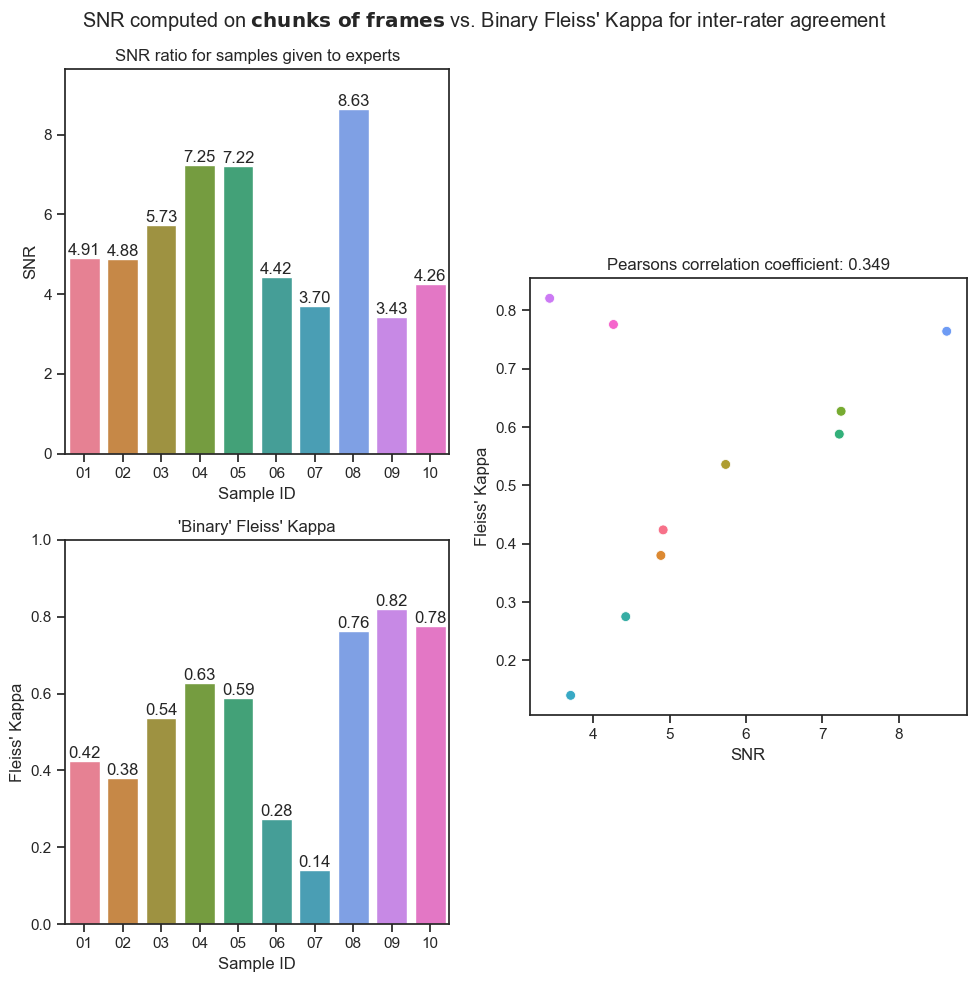

In [79]:
# create a figure with 3 subplots
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])

# plot barplot of snr_experts
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x=slice_ids, hue=slice_ids, y=snr_chunks_list, ax=ax1, legend=False, orient="v"
)
ax1.set_title("SNR ratio for samples given to experts")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("SNR")
ax1.set_ylim(0, max(snr_chunks_list) + 1)
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")
ax1.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot barplot of binary_fleiss_kappas
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
    orient="v",
)
ax2.set_title("'Binary' Fleiss' Kappa")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
ax2.set_ylim(0, 1)
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")
ax2.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot scatter plot of snr_experts_list vs binary_fleiss_kappas_list
ax3 = fig.add_subplot(gs[:, 1])
sns.scatterplot(
    x=snr_chunks_list,
    y=binary_fleiss_kappas_list,
    hue=slice_ids,
    hue_order=slice_ids,
    ax=ax3,
    legend=False,
    s=50,
)
ax3.set_title("Pearsons correlation coefficient: %.3f" % binary_chunks_corr)
ax3.set_xlabel("SNR")
ax3.set_ylabel("Fleiss' Kappa")
ax3.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# set the whole plot title
fig.suptitle(
    r"SNR computed on $\bf{chunks\ of\ frames}$ vs. Binary Fleiss' Kappa for inter-rater agreement"
)

# remove empty space between columns
fig.subplots_adjust(wspace=0)
fig.tight_layout()

# display the plot
plt.show()

In [95]:
# # visualize pixels in events above percentile
# for slice_id in slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     if movie_id not in sample_ids:
#         continue

#     # get chunk of frames
#     start_id = start_ids[slice_id]
#     end_id = end_ids[slice_id]
#     x_chunk = xs[movie_id][start_id : end_id + 1]
#     y_chunk = ys[movie_id][start_id : end_id + 1]

#     # compute percentile
#     percentile = 60
#     events_percentile = np.percentile(x_chunk[y_chunk != 0], percentile)
#     percentile_mask = np.logical_and(x_chunk > events_percentile, y_chunk != 0)

#     viewer = napari.Viewer()
#     viewer.add_image(
#         x_chunk, name=f"movie {slice_to_movie_id[slice_id]}", colormap="gray", opacity=0.5
#     )
#     viewer.add_labels(y_chunk, name=f"events in movie {slice_to_movie_id[slice_id]}", opacity=0.5)
#     viewer.add_labels(
#         percentile_mask, name="pixels in events above percentile", blending="additive"
#     )

#### Compute average SNR of events present in each slice

In [80]:
# load instance masks for all samples
percentile = 99.9
ys_instances = load_annotations_ids(
    data_folder=dataset_path, ids=sample_ids, mask_names="event_label"
)

# initialize dictionary to store average SNR for each slice_id
avg_snr_events = {}

for slice_id in slice_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]

    if movie_id not in sample_ids:
        continue

    x = xs[movie_id]
    y = ys[movie_id]
    y = ys_instances[movie_id]

    # get all unique event labels in the frame
    event_labels = np.unique(y[frame_id])
    # remove 0 from event_labels
    event_labels = event_labels[event_labels != 0]

    # initialize list to store SNR for each event instance
    snr_list = []

    # loop through each event label
    for event_label in event_labels:
        event_roi = y == event_label

        # get first and last frames of event_roi
        event_indices_list = np.where(event_roi == 1)[0]
        start_id = event_indices_list[0]
        end_id = event_indices_list[-1]

        # compute signal-to-noise ratio
        snr_event = compute_snr(
            x=x[start_id:end_id],
            y=y[start_id:end_id],
            event_roi=event_roi[start_id:end_id],
            percentile=percentile,
        )
        snr_list.append(snr_event)

    # compute the average SNR for all event instances in the slice_id
    avg_snr_events[slice_id] = np.mean(snr_list)

#### Compute correlation of average of events present in each slice

In [81]:
# check if there is a correlation between snr and fleiss kappas
avg_snr_events_list = list(avg_snr_events.values())
events_avg_corr, _ = pearsonr(avg_snr_events_list, fleiss_kappas_list)
print("Pearsons correlation for classified segmentation: %.3f" % events_avg_corr)

# check if there is a correlation between snr and binary fleiss kappas
binary_events_avg_corr, _ = pearsonr(avg_snr_events_list, binary_fleiss_kappas_list)
print("Pearsons correlation for binary segmentation: %.3f" % binary_events_avg_corr)

Pearsons correlation for classified segmentation: 0.172
Pearsons correlation for binary segmentation: 0.289


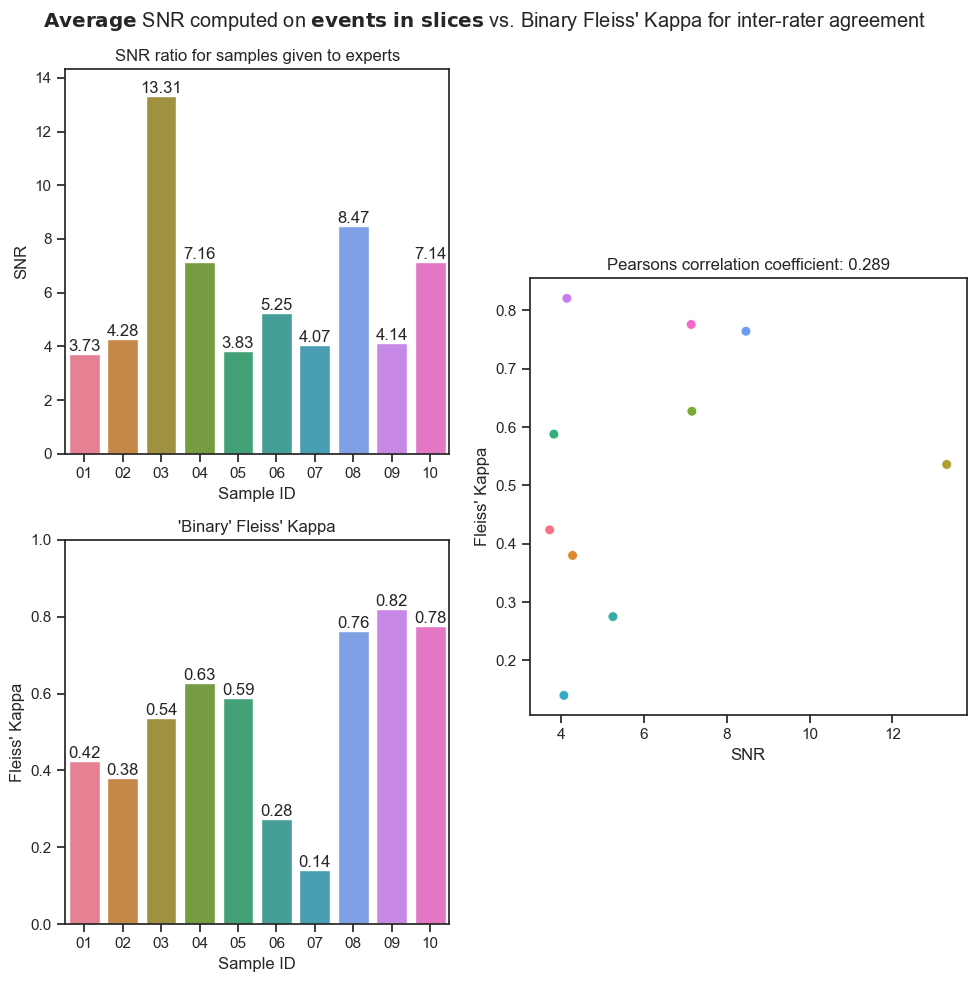

In [82]:
# create a figure with 3 subplots
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 2])

# plot barplot of snr_experts
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x=slice_ids, hue=slice_ids, y=avg_snr_events_list, ax=ax1, legend=False, orient="v"
)
ax1.set_title("SNR ratio for samples given to experts")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("SNR")
ax1.set_ylim(0, max(avg_snr_events_list) + 1)
for bars in ax1.containers:
    ax1.bar_label(bars, fmt="%.2f")
ax1.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot barplot of binary_fleiss_kappas
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(
    x=slice_ids,
    hue=slice_ids,
    y=binary_fleiss_kappas_list,
    ax=ax2,
    legend=False,
    orient="v",
)
ax2.set_title("'Binary' Fleiss' Kappa")
ax2.set_xlabel("Sample ID")
ax2.set_ylabel("Fleiss' Kappa")
ax2.set_ylim(0, 1)
for bars in ax2.containers:
    ax2.bar_label(bars, fmt="%.2f")
ax2.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# plot scatter plot of snr_experts_list vs binary_fleiss_kappas_list
ax3 = fig.add_subplot(gs[:, 1])
sns.scatterplot(
    x=avg_snr_events_list,
    y=binary_fleiss_kappas_list,
    hue=slice_ids,
    hue_order=slice_ids,
    ax=ax3,
    legend=False,
    s=50,
)
ax3.set_title("Pearsons correlation coefficient: %.3f" % binary_events_avg_corr)
ax3.set_xlabel("SNR")
ax3.set_ylabel("Fleiss' Kappa")
ax3.set_box_aspect(1)  # Set the aspect ratio of axes to be equal

# set the whole plot title
fig.suptitle(
    r"$\bf{Average}$ SNR computed on $\bf{events\ in\ slices}$ vs. Binary Fleiss' Kappa for inter-rater agreement"
)

# remove empty space between columns
fig.subplots_adjust(wspace=0)
fig.tight_layout()

# display the plot
plt.show()

In [60]:
# # visualize pixels in events above percentile
# for slice_id in slice_ids:
#     movie_id = slice_to_movie_id[slice_id]
#     frame_id = slice_to_frame_id[slice_id]

#     if movie_id not in sample_ids:
#         continue

#     x = xs[movie_id]
#     y = ys[movie_id]
#     y = ys_instances[movie_id]

#     # get all unique event labels in the frame
#     event_labels = np.unique(y[frame_id])
#     # remove 0 from event_labels
#     event_labels = event_labels[event_labels != 0]

#     viewer = napari.Viewer()
#     viewer.add_image(
#         x,
#         name=f"movie {slice_to_movie_id[slice_id]}, for frame {frame_id}",
#         colormap="gray",
#         opacity=0.5,
#     )
#     viewer.add_labels(
#         y, name=f"events in movie {slice_to_movie_id[slice_id]}", opacity=0.5
#     )

#     # compute percentile
#     percentile = 60
#     # loop through each event label
#     for event_label in event_labels:
#         event_roi = y == event_label

#         # get first and last frames of event_roi
#         event_indices_list = np.where(event_roi == 1)[0]
#         start_id = event_indices_list[0]
#         end_id = event_indices_list[-1]

#         x_chunk = x[start_id:end_id]
#         y_chunk = y[start_id:end_id]

#         events_percentile = np.percentile(x_chunk[y_chunk != 0], percentile)
#         percentile_mask = np.logical_and(x > events_percentile, event_roi)

#         viewer.add_labels(
#             percentile_mask, name=f"pixels in event {event_label} above percentile", blending="additive"
#         )

## Rado's functions implementation

In [68]:
from skimage.morphology import binary_closing
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes


def estimate_cell_mask(cell_img: np.ndarray) -> np.ndarray:
    cell_img = np.mean(cell_img, axis=0)

    # Normalize cell image
    cell_img = cell_img / np.max(cell_img)

    # Calculate a threshold using Otsu's method
    cell_thrs = threshold_otsu(
        cell_img[
            (cell_img > np.percentile(cell_img, 1))
            & (cell_img < np.percentile(cell_img, 99))
        ]
    )

    # Create a binary thresholded cell image
    cell_img_bw_thrs = binary_fill_holes(cell_img > cell_thrs)

    # Perform edge detection and dilation to obtain cell mask
    edges_sobel = (
        cell_img > np.max(cell_img) * 0.5
    )  # You might need to fine-tune this threshold
    edges_canny = cell_img_bw_thrs

    se = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # Define a structuring element
    bw_dil_sobel = binary_closing(edges_sobel, se)
    bw_dil_canny = binary_closing(edges_canny, se)

    cell_mask = bw_dil_sobel | bw_dil_canny | cell_img_bw_thrs
    cell_mask = binary_fill_holes(cell_mask)

    return cell_mask


def estimate_snr(x: np.ndarray, y: np.ndarray, event_type: str) -> float:
    # Convert the image series to double
    x = x.astype(float)

    # Estimate the cell mask
    cell_mask = estimate_cell_mask(x)

    # Add the mask of events to the cell mask
    cell_mask = cell_mask | np.any(y, axis=0)
    cell_mask = np.repeat(cell_mask[np.newaxis, :, :], x.shape[0], axis=0)

    # Calculate the 99th percentile of event mask as the peak amplitude of events
    p = 99

    if event_type == "sparks":
        avg_events = np.percentile(x[cell_mask & (y == 1)], p)
    elif event_type == "puffs":
        avg_events = np.percentile(x[cell_mask & (y == 3)], p)
    elif event_type == "waves":
        avg_events = np.percentile(x[cell_mask & (y == 2)], p)
    elif event_type == "all":
        avg_events = np.percentile(x[cell_mask & np.isin(y, [1, 2, 3])], p)
    else:
        raise ValueError(
            "event_type must be one of the following: sparks, puffs, waves or all"
        )

    # Calculate the average signal from cell areas without events
    avg_baseline = np.mean(x[(y == 0) & cell_mask])

    # Estimate noise standard deviation
    sd_noise = np.std(x[(y == 0) & cell_mask])

    # Calculate SNR
    snr = (avg_events - avg_baseline) / sd_noise

    return snr